# Super convergence

In [ ]:
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)
#

import torch
from torch import optim, nn
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset, random_split

## Upload database

In [ ]:
data_path = '/home/juangomez/Desktop/ML/Cursos/Pepe Cantoral/datasets'
num_train = 50000
num_val = 5000
num_test = 5000
batch_size = 64

transform_cifar1_train = T.Compose([
    T.RandomHorizontalFlip(p=0.3),
    T.ColorJitter(brightness=0.1, contrast=0.1, hue=0.05),
    T.RandomApply([T.RandomRotation(10), T.Resize(40), T.CenterCrop(32)], p=0.1),
    T.ToTensor(),
    T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
])

transform_cifar10_test = T.Compose([
    T.ToTensor(),
    T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
])


train_dataset = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transform_cifar1_train)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

test_dataset = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform=transform_cifar10_test)


val_dataset, test_dataset = random_split(
    test_dataset,
    [num_val, num_test],
)


val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
)


In [ ]:
# this make a generator
data_iter = iter(train_loader)
# get the first batch
images, labels = next(data_iter)
print(images.shape)

torch.Size([64, 3, 32, 32])


In [ ]:
# this make a generator
data_iter = iter(test_loader)
# get the first batch
images, labels = next(data_iter)
print(images.shape)

torch.Size([64, 3, 32, 32])


# Choose Device

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


## Show images

Show the image 0 of the batch 35. Class: 


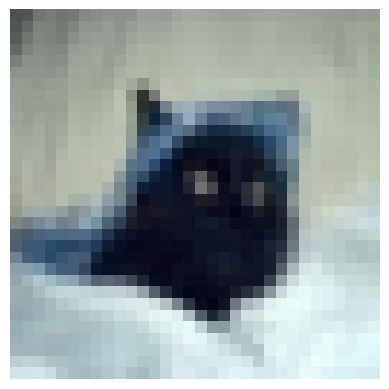

In [ ]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

idx= np.random.randint(len(test_loader))
print(f'Show the image 0 of the batch {idx}. Class: ')
image = test_loader.dataset[idx][0]
image = (image- image.min())/(image.max()-image.min())
plot_figure(image)

# Accuracy


In [ ]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    cost = 0
    model.eval()
    model = model.to(device)
    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.to(device)
            yi = yi.to(device)
            scores = model(xi)
            cost += F.cross_entropy(scores, yi).item()
            # Compute the max in each row for each image of the batch
            _, preds = scores.max(1)
            num_correct += (preds == yi).sum()
            num_total += len(yi)
        return cost/len(loader), float(num_correct) / num_total

# Find max Learning Rate
Here, we search for the maximum learning rate. This is not necessarily the best one, but it helps us define a suitable range


In [ ]:


def find_lr(model, optimizer, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    # Compute the factor to increase the learning rate
    # This factor allow to increase the learning rate slowly in the first iterations
    # and then increase rapidly
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val

    #this allows you to update the learning rate
    optimizer.param_groups[0]['lr'] = lr


    avg_loss, loss, acc = 0.0, 0.0, 0.0
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long)
        optimizer.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)

        # Here delete the noise in the loss
        loss = beta*loss + (1-beta)*cost.item()
        # Correct the loss because the loss in the first iterations is very low
        avg_loss = loss/(1 - beta**i)

        acc_ = ((torch.argmax(scores, dim=1) == y).sum()/scores.size(0))
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        # Save the values

        #accuracies.append(acc.item())
        accuracies.append(acc_.item())
        # Accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)


        #step

        cost.backward()
        optimizer.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.6f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimizer.param_groups[0]['lr'] = lr

    return log_lrs, losses, accuracies

# Training Loop Using scheduler (OneCycleLearningRate)

In [ ]:
def train(model, optimizer, scheduler=None, epochs=100):

    model = model.to(device = device)
    val_loss_history = []
    train_loss_history = []
    val_acc_history = []
    train_acc_history = []
    lrs = []
    train_cost = 0.0
    val_cost = 0.0
    train_cost_acum = 0.0


    for epoch in range(epochs):

        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0

        for xi, yi in train_loader:
            model.train()
            xi = xi.to(device = device, dtype=torch.float32)
            yi = yi.to(device = device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input=scores, target=yi.squeeze())

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            if scheduler: scheduler.step()

            # This is necesary to compute the accuracy in the training
            train_correct_num += (torch.argmax(scores, dim=1) == yi).sum()
            train_total += len(yi)
            train_cost_acum += cost.item()


        train_acc = float(train_correct_num) / train_total
        val_cost, val_acc = accuracy(model, val_loader)
        val_loss_history.append(val_cost)
        train_loss_history.append(cost.item())
        val_acc_history.append(val_acc)
        train_acc_history.append(train_acc)
        lrs.append(optimizer.param_groups[0]['lr'])


        train_acc = float(train_correct_num) / train_total
        train_cost = train_cost_acum / len(train_loader)
        print(f'Epoch:{epoch}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
                      f' train acc: {train_acc:.4f}, val acc: {val_acc:4f}, total: {train_total},'
                      f' lr: {optimizer.param_groups[0]["lr"]:.6f}')
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

# RESNET56

In [ ]:
conv_k_3 = lambda channel1, channel2, stride: nn.Conv2d(
    in_channels=channel1,
    out_channels=channel2,
    kernel_size=3,
    stride=stride,
    padding=1)

In [ ]:
class residual_block(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1, change_size = True):
        super(residual_block, self).__init__()
        self.conv1 = conv_k_3(in_channel, out_channel, stride)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = conv_k_3(out_channel, out_channel, 1)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.change_size = change_size
        if change_size:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channel)
            )
    def forward(self, x):
        identity = x if not self.change_size else self.residual(x)
        y = self.conv1(x)
        y = self.bn1(y)
        y = F.relu(y)

        y = self.conv2(y)
        y = self.bn2(y)

        y = y + identity
        y = F.relu(y)
        return y

In [ ]:
class ResNet56(nn.Module):
    def __init__(self, n = 9, num_classes= 10):
        super(ResNet56, self).__init__()
        self.conv1 = conv_k_3(3, 16, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.block1 = self.create_block(n=9, in_channel=16, out_channel=16, stride=1, change_size=False)
        self.block2 = self.create_block(n=9, in_channel=16, out_channel=32, stride=2, change_size=True)
        self.block3 = self.create_block(n=9, in_channel=32, out_channel=64, stride=2, change_size=True)
        self.fc = nn.Linear(64, num_classes)



    def create_block(self, n, in_channel, out_channel, stride=1, change_size=True):
        block = [residual_block(in_channel, out_channel, stride, change_size=change_size)]
        for i in range(n-1):
            block.append(residual_block(out_channel, out_channel, stride=1, change_size=False))
        return nn.Sequential(*block)

    def forward(self, x):
        y = self.conv1(x)
        y = self.bn1(y)
        y = F.relu(y)
        y = self.block1(y)
        y = self.block2(y)
        y = self.block3(y)

        # the second param of adaptive is the size of the output
        # in this case is 1x1x#canales
        y = F.adaptive_avg_pool2d(y, (1,1))
        # is similar to flatten
        y = y.view(y.size(0), -1)
        y= self.fc(y)
        return y

In [ ]:
model_resnet56 = ResNet56()
optimizer_resnet56 = optim.SGD(model_resnet56.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)


## Explore Learning Rate

In [ ]:
lg_lr, losses, accuracies = find_lr(model_resnet56, optimizer_resnet56, start_val=1e-6, end_val=1.0)

cost:2.5260, lr: 0.000001, acc: 0.1562
cost:2.8522, lr: 0.000001, acc: 0.0938
cost:2.8165, lr: 0.000001, acc: 0.0625
cost:3.0090, lr: 0.000001, acc: 0.0312
cost:2.9739, lr: 0.000001, acc: 0.0781
cost:3.0405, lr: 0.000001, acc: 0.0625
cost:2.6795, lr: 0.000001, acc: 0.0938
cost:2.9325, lr: 0.000001, acc: 0.0625
cost:2.8863, lr: 0.000001, acc: 0.0781
cost:2.7450, lr: 0.000001, acc: 0.1562
cost:2.7444, lr: 0.000001, acc: 0.0469
cost:2.7835, lr: 0.000001, acc: 0.0781
cost:2.9625, lr: 0.000001, acc: 0.0625
cost:2.7222, lr: 0.000001, acc: 0.1406
cost:2.9568, lr: 0.000001, acc: 0.0938
cost:2.9008, lr: 0.000001, acc: 0.1250
cost:2.7967, lr: 0.000001, acc: 0.0938
cost:2.8993, lr: 0.000001, acc: 0.0469
cost:2.8661, lr: 0.000001, acc: 0.1094
cost:2.9333, lr: 0.000001, acc: 0.1562
cost:2.7434, lr: 0.000001, acc: 0.1094
cost:2.9778, lr: 0.000001, acc: 0.0938
cost:2.6303, lr: 0.000001, acc: 0.1875
cost:2.8592, lr: 0.000002, acc: 0.1250
cost:2.7498, lr: 0.000002, acc: 0.1719
cost:2.9141, lr: 0.000002

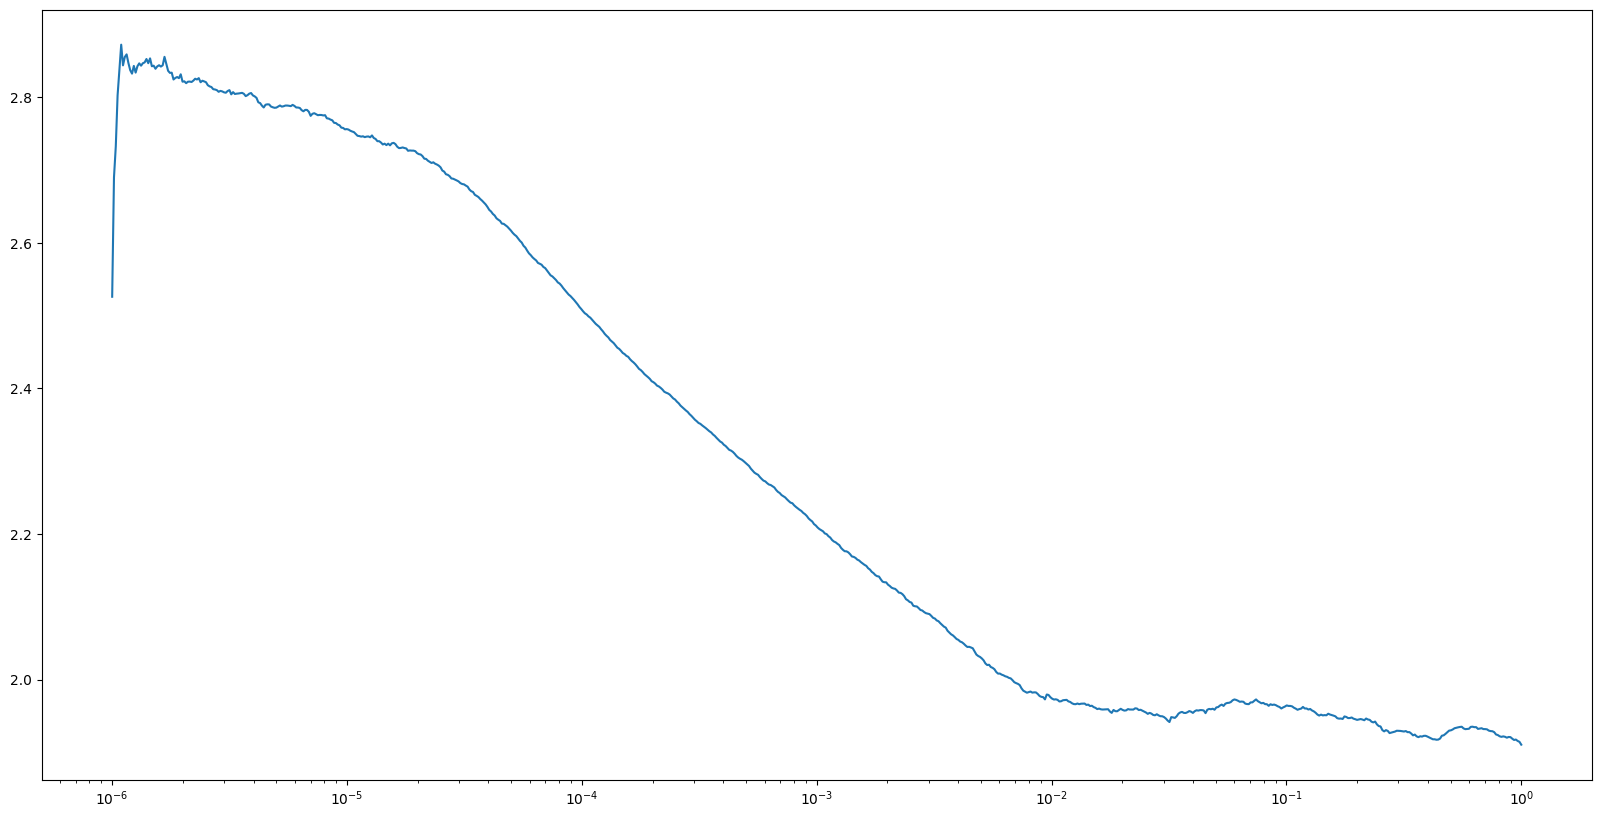

In [ ]:
f1, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
plt.show()

In [ ]:
model_resnet56 = ResNet56()
optimizer_resnet56 = optim.SGD(model_resnet56.parameters(), lr=0.1, momentum=0.95, weight_decay=1e-4)

epochs = 20
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer_resnet56,
    max_lr= 2e-1,
    steps_per_epoch=len(train_loader),
    epochs=epochs,
    pct_start= 0.43,
    div_factor=10,
    final_div_factor=1000,
    three_phase=True,
    verbose=False
)

train_loss_history , val_loss_history, train_acc_history, val_acc_history = train(
    model_resnet56,
    optimizer = optimizer_resnet56,
    scheduler=scheduler,
    epochs=epochs
)

Epoch:0, train cost: 1.791474, val cost: 1.406289, train acc: 0.3231, val acc: 0.487800, total: 50000, lr: 0.025940
Epoch:1, train cost: 1.273979, val cost: 1.137994, train acc: 0.5396, val acc: 0.597000, total: 50000, lr: 0.042977
Epoch:2, train cost: 0.979916, val cost: 0.928468, train acc: 0.6547, val acc: 0.680600, total: 50000, lr: 0.068861
Epoch:3, train cost: 0.802338, val cost: 0.755457, train acc: 0.7207, val acc: 0.742400, total: 50000, lr: 0.100176
Epoch:4, train cost: 0.705311, val cost: 0.684816, train acc: 0.7551, val acc: 0.762000, total: 50000, lr: 0.132788
Epoch:5, train cost: 0.644072, val cost: 0.755308, train acc: 0.7788, val acc: 0.748000, total: 50000, lr: 0.162391
Epoch:6, train cost: 0.589855, val cost: 0.682131, train acc: 0.7960, val acc: 0.775800, total: 50000, lr: 0.185079
Epoch:7, train cost: 0.546676, val cost: 0.624777, train acc: 0.8124, val acc: 0.797400, total: 50000, lr: 0.197855
Epoch:8, train cost: 0.515571, val cost: 0.563623, train acc: 0.8234, va

## Save model

In [ ]:
torch.save(model_resnet56.state_dict(), 'models/40-resnet56.pth')
